In [49]:
import sys; sys.path.append('..')
from feature_extraction import bow_occurrences, bow_tfidf, bow_tfidf_df
from preprocess_tweets import read_annotated_tweets, clean_tweets
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import os
from numpy import mean, std
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [50]:
df = read_annotated_tweets(os.path.abspath('../data/raw/england_italy_all_tweets.csv'))
clean_tweets(df)

/home/anze/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3364: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [51]:


ngrams = bow_tfidf(df['tweet_text'], (1,2))

In [52]:
#print(ngrams)

X_train = ngrams[:298]
Y_train = df['label'].iloc[:298]

Y_test = ngrams[299:]

#print(ngrams.shape)
#print(X_train.shape)
#print(Y_test.shape)

#print(X_train)
#print(Y_train)

In [53]:
mb_model = MultinomialNB()

mb_model.fit(X_train, Y_train)



MultinomialNB()

5655
3169
331015


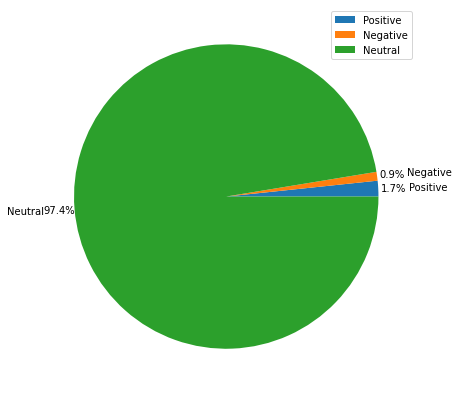

In [54]:
predicted = mb_model.predict(Y_test)

positives = list(filter(lambda x: str(x) == 'Positive', predicted))
negatives = list(filter(lambda x: str(x) == 'Negative', predicted))
neutrals = list(filter(lambda x: str(x) == 'Neutral', predicted))

print(len(positives))
print(len(negatives))
print(len(neutrals))

labels = ['Positive', 'Negative', 'Neutral']
sizes = [len(positives), len(negatives), len(neutrals)]

plt.pie(sizes, labels=labels, autopct='%.1f%%', pctdistance=1.1, labeldistance=1.2)
plt.legend()
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.savefig('../figs/match_sentiment_pie.png')
plt.show()

In [55]:
timestamps = df['timestamp'].iloc[299:].to_list()

#print(timestamps)

timestamp_label_df = pd.DataFrame(list(zip(timestamps, predicted)), columns=['timestamp', 'label'])

timestamp_label_df['timestamp'] = pd.to_datetime(timestamp_label_df['timestamp'])

print(timestamp_label_df)


                       timestamp    label
0      2021-07-11 18:06:59+00:00  Neutral
1      2021-07-11 18:06:58+00:00  Neutral
2      2021-07-11 18:07:01+00:00  Neutral
3      2021-07-11 18:06:58+00:00  Neutral
4      2021-07-11 18:07:02+00:00  Neutral
...                          ...      ...
339834 2021-07-11 22:41:37+00:00  Neutral
339835 2021-07-11 22:41:37+00:00  Neutral
339836 2021-07-11 22:41:37+00:00  Neutral
339837 2021-07-11 22:41:38+00:00  Neutral
339838 2021-07-11 22:41:38+00:00  Neutral

[339839 rows x 2 columns]


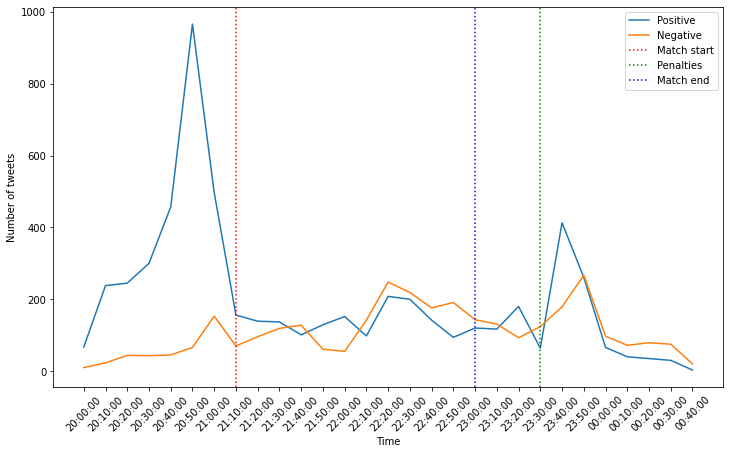

In [66]:
#timestamp_label_df = timestamp_label_df.set_index('timestamp')
timestamp_label_df['timestamp'] = timestamp_label_df['timestamp'].dt.tz_convert('Europe/Ljubljana')


positives_df = timestamp_label_df[timestamp_label_df["label"] == "Positive"]
negatives_df = timestamp_label_df[timestamp_label_df["label"] == "Negative"]
neutrals_df = timestamp_label_df[timestamp_label_df["label"] == "Neutral"]

grouped__pos_df = positives_df.groupby(pd.Grouper(key='timestamp', axis=0, freq='10min')).count()
grouped__neg_df = negatives_df.groupby(pd.Grouper(key='timestamp', axis=0, freq='10min')).count()
grouped__neu_df = neutrals_df.groupby(pd.Grouper(key='timestamp', axis=0, freq='10min')).count()


""" print(grouped__pos_df.shape)
print(grouped__neg_df.shape)
print(grouped__neu_df.shape)

print(grouped__pos_df.iloc[-1])
print(grouped__neg_df.iloc[-1])
print(grouped__neu_df.iloc[-1]) """

#print(grouped__pos_df.index)

dates = [x.strftime("%H:%M:%S") for x in grouped__pos_df.index]


plt.figure(figsize=(12,7))
plt.plot(dates, grouped__pos_df['label'], label='Positive')
plt.plot(dates, grouped__neg_df['label'], label='Negative')
#plt.plot(dates, grouped__neu_df['label'], label='Neutral')
plt.xlabel('Time')
plt.ylabel('Number of tweets')
plt.xticks(rotation=45)
plt.axvline(dates[7], color='r', label="Match start", linestyle=':')
plt.axvline(dates[21], color='g', label="Penalties", linestyle=':')
plt.axvline(dates[18], color='b', label="Match end", linestyle=':')
plt.legend()
plt.savefig("../figs/match_sentiment.png")
plt.show()